```
 ---
title: BioPAXPpathwaySteps sequence
tags: BioPAX, pathway, SPARQL, Reactome
lang: en
version: 0.12
date: 2024-06-01
---
```

In [1]:
#import collections
#import graphviz
#import importlib
import IPython
#import json
import math
#import matplotlib.pyplot as plt
import networkx as nx
#import os
import pandas
import pygraphviz as pgv
#import rdflib
#import rdflib.namespace
#import scipy.stats
import sparqldataframe
#import statsmodels.stats.multitest
from SPARQLWrapper import SPARQLWrapper, JSON
#import sys

In [2]:
reactomeVersion = 81 # 2024-03-18
#chebiVersion = 222 # was 219 # was 207
endpointURL = "http://localhost:3030/reactome/query"
#endpointURL = "http://localhost:3030/chebi/query"
#endpointURL = "http://localhost:3030/reactomeChEBI/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

PREFIX reactome: <http://www.reactome.org/biopax/{}/48887#>
""".format(reactomeVersion)

biopaxURI = "http://www.biopax.org/release/biopax-level3.owl#"
reactomeURI = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion)
uniprotURI = "http://purl.uniprot.org/uniprot/"

In [4]:
colorPathway = "#e6ffff"
colorPathwayStep = "#e8ffe8"
colorReaction = "lightyellow"

In [5]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] if vName in row.keys() else "&nbsp;" for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

In [6]:
def getPathwayURIbyName(pathwayName):
    query="""
SELECT DISTINCT ?pathwayURI ?pathwayReactomeID
WHERE {
  ?pathwayURI bp3:name|bp3:displayName \"""" + pathwayName + """\" .
  ?pathwayURI bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayReactomeID ] .
}
"""
    #df = sparqldataframe.query(endpointURL, prefixes+query)
    #df

    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

In [7]:
def getPathwayURIandNameByIdent(pathwayReactomeID):
    query="""
SELECT DISTINCT ?pathwayURI ?pathwayName
WHERE {
  #?pathwayURI bp3:name ?pathwayName .
  ?pathwayURI bp3:displayName ?pathwayName .
  #?pathwayURI bp3:name|bp3:displayName ?pathwayName .
  ?pathwayURI bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id \"""" + pathwayReactomeID + """\" ] .
}
"""
    #df = sparqldataframe.query(endpointURL, prefixes+query)
    #df

    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

In [8]:
displaySparqlResults(getPathwayURIbyName("Epidermal Growth Factor Receptor (EGFR) signaling"))

In [9]:
displaySparqlResults(getPathwayURIandNameByIdent("R-HSA-8981373"))

# BioPAX data schema

![Biopax instance diagram (Reactome)](./images/biopax-v3.png)

# 1. Pathway metrics

> **Key points:** 
> -  2698 pathways
> - 17573 pathway steps
>     - composition
>         - each PathwayStep has from 1 to 23 stepProcess
>     - topology
>         - from 0 to 94 nextStep
>         - 5469 isolated PathwaySteps (have neither previous step nor next step)
>         - 12104 (=17573 - 5469) connected PathwaySteps (have either a previous step or a next step)
>         - 915 connected components (nextStep relation)
>             - from 2 to 6691 PathwaySteps

In [10]:
query="""
# number of Pathways

SELECT (COUNT(DISTINCT ?pathway) AS ?nbPathways)
WHERE {
  ?pathway rdf:type bp3:Pathway .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [11]:
query="""
# number of PathwaySteps

SELECT (COUNT(DISTINCT ?step) AS ?nbPathwaySteps)
WHERE {
  ?step rdf:type bp3:PathwayStep .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [13]:
query="""
# relations applicable to PathwaySteps

SELECT DISTINCT ?rel
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step ?rel ?val .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

## 1.1 Number of nextStep

In [10]:
query="""
# distribution of the number of nextStep

SELECT ?step (COUNT(DISTINCT ?nextStep) AS ?nbNextStep)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  OPTIONAL { ?step bp3:nextStep ?nextStep }
}
GROUP BY ?step
ORDER BY DESC(?nbNextStep)
LIMIT 5
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [11]:
query="""
# distribution of the number of nextStep

SELECT ?step (COUNT(DISTINCT ?nextStep) AS ?nbNextStep)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  OPTIONAL { ?step bp3:nextStep ?nextStep }
}
GROUP BY ?step
ORDER BY DESC(?nbNextStep)
#LIMIT 3
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbNextStep'].hist(xrot=90)

> **Interpretation:** most `bp3:PathwayStep` have 0..3 nextStep, some have up to 11, and 1 has 94.

## 1.2 number of stepProcess

In [12]:
query="""
# distribution of the number of stepProcess

SELECT ?step (COUNT(DISTINCT ?stepProc) AS ?nbStepProcesses)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  OPTIONAL { ?step bp3:stepProcess ?stepProc }
}
GROUP BY ?step
ORDER BY DESC(?nbStepProcesses)
LIMIT 10
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [13]:
query="""
# distribution of the number of stepProcess

SELECT ?step (COUNT(DISTINCT ?stepProc) AS ?nbStepProcesses)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  OPTIONAL { ?step bp3:stepProcess ?stepProc }
}
GROUP BY ?step
ORDER BY ASC(?nbStepProcesses)
LIMIT 10
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

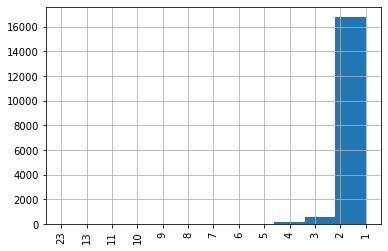

In [14]:
query="""
# distribution of the number of stepProcess

SELECT ?step (COUNT(DISTINCT ?stepProc) AS ?nbStepProcesses)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  OPTIONAL { ?step bp3:stepProcess ?stepProc }
}
GROUP BY ?step
ORDER BY DESC(?nbStepProcesses)
#LIMIT 10
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbStepProcesses'].hist(xrot=90)

## 1.3 Number of proteins and protein references

In [15]:
query="""
# number of Proteins

SELECT (COUNT(DISTINCT ?prot) AS ?nbProteins)
WHERE {
  ?prot rdf:type bp3:Protein .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [16]:
query="""
# number of ProteinReferences

SELECT (COUNT(DISTINCT ?protRef) AS ?nbProteinReferences)
WHERE {
  ?protRef rdf:type bp3:ProteinReference .
  
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [17]:
query="""
# number of ProteinReferences associated to at least 1 Protein

SELECT (COUNT(DISTINCT ?protRef) AS ?nbProteinReferences)
WHERE {
  ?prot rdf:type bp3:Protein .
  ?prot bp3:entityReference ?protRef .
  ?protRef rdf:type bp3:ProteinReference .
  
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [18]:
query="""
# number of ProteinReferences with a mapping to UniProt

SELECT (COUNT(DISTINCT ?protRef) AS ?nbProteinReferences)
WHERE {
  ?protRef rdf:type bp3:ProteinReference .
  ?protRef bp3:xref ?xref .
  ?xref bp3:db "UniProt" .
  ?xref bp3:id ?uniprotId .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [19]:
query="""
# number of UniProt identifiers

SELECT (COUNT(DISTINCT ?uniprotId) AS ?nbProteinsUniprot)
WHERE {
  ?protRef rdf:type bp3:ProteinReference .
  ?protRef bp3:xref ?xref .
  ?xref bp3:db "UniProt" .
  ?xref bp3:id ?uniprotId .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Interpretation:**
> - 11852 distinct `bp3:ProteinReference`s
> - 11460 of which (97%) have a mapping to 11460 distinct UniProt identifiers

In [20]:
query="""
# number of Proteins associated to a PathwayStep

SELECT (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:stepProcess ?proc .
  #?proc (bp3:left|bp3:right)/(bp3:component*) ?protein .
  ?proc (bp3:left|bp3:right|bp3:controller)/(bp3:component*) ?protein .
  #?proc (bp3:left|bp3:right|bp3:controller|bp3:cofactor)/(bp3:component*) ?protein .
  ?protein rdf:type bp3:Protein .
  #?protein bp3:entityReference ?protRef.
  #?protRef rdf:type bp3:ProteinReference .
  #?protRef bp3:xref ?xref .
  #?xref bp3:db "UniProt" .
  #?xref bp3:id ?uniprotId .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [21]:
query="""
# number of ProteinReferences associated to a PathwayStep

SELECT (COUNT(DISTINCT ?protRef) AS ?nbProteinReferences)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:stepProcess ?proc .
  #?proc (bp3:left|bp3:right)/(bp3:component*) ?protein .
  ?proc (bp3:left|bp3:right|bp3:controller)/(bp3:component*) ?protein .
  #?proc (bp3:left|bp3:right|bp3:controller)/((bp3:component|bp3:memberPhysicalEntity)*) ?protein .
  #?proc (bp3:left|bp3:right|bp3:controller|bp3:cofactor)/(bp3:component*) ?protein .
  ?protein rdf:type bp3:Protein .
  ?protein bp3:entityReference ?protRef.
  ?protRef rdf:type bp3:ProteinReference .
  #?protRef bp3:xref ?xref .
  #?xref bp3:db "UniProt" .
  #?xref bp3:id ?uniprotId .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Interpretation:**
> - `.../(bp3:component*)` -> 6820 distinct ProteinReferences (57% of the 11852 ProteinReferences)
> - `.../((bp3:component|bp3:memberPhysicalEntity)*)` -> 11838 distinct ProteinReferences (99% of the 11852 ProteinReferences)

In [22]:
query="""
# properties leading to a protein

SELECT DISTINCT ?p
WHERE {
  ?protein rdf:type bp3:Protein .
  ?s ?p ?protein .
}
ORDER BY ?p
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [26]:
query="""
# nb of protein accessible via each property

SELECT ?p (COUNT(DISTINCT ?protein) AS ?nbProteins)
WHERE {
  ?protein rdf:type bp3:Protein .
  ?s ?p ?protein .
}
GROUP BY ?p
ORDER BY DESC(?nbProteins)
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [28]:
query="""
# types of the entities that have a memberPhysicalEntity that is a Protein

SELECT DISTINCT ?sType
WHERE {
  ?protein rdf:type bp3:Protein .
  ?s bp3:memberPhysicalEntity/(bp3:component*) ?protein .
  ?s rdf:type ?sType .
}
ORDER BY ?sType
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

# 2. Consistency

# 3. PathwayStep sequence

In [10]:
stepGraph = nx.DiGraph()

In [11]:
stepGraph.add_node("riri")
stepGraph.add_node("fifi")
stepGraph.add_node("loulou")
stepGraph.add_edge("riri", "fifi")
for cc in nx.connected_components(stepGraph.to_undirected()):
    print(cc)
stepGraph.clear()

{'riri', 'fifi'}
{'loulou'}


In [12]:
query="""
# isolated PathwaySteps

SELECT (COUNT(DISTINCT ?step) AS ?nbIsolatedPathwaySteps)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  FILTER NOT EXISTS {
    ?step bp3:nextStep ?nextStep .
    ?nextStep rdf:type bp3:PathwayStep .
  }
  FILTER NOT EXISTS {
    ?previousStep bp3:nextStep ?step .
    ?previousStep rdf:type bp3:PathwayStep .
  }
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [13]:
query="""
# isolated PathwaySteps

SELECT (COUNT(DISTINCT ?step) AS ?nbConnectedPathwaySteps)
WHERE {
  ?step rdf:type bp3:PathwayStep .
  {
    ?step bp3:nextStep ?nextStep .
    ?nextStep rdf:type bp3:PathwayStep .
  }
  UNION
  {
    ?previousStep bp3:nextStep ?step .
    ?previousStep rdf:type bp3:PathwayStep .
  }
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [14]:
query="""
# sequences of PathwaySteps

SELECT DISTINCT ?step ?nextStep
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?nextStep .
  ?nextStep rdf:type bp3:PathwayStep .
}
LIMIT 3
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [15]:
query="""
# sequences of PathwaySteps

SELECT DISTINCT ?step ?nextStep
WHERE {
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?nextStep .
  ?nextStep rdf:type bp3:PathwayStep .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    #print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
    startNode = result["step"]["value"].replace(reactomeURI, "")
    endNode = result["nextStep"]["value"].replace(reactomeURI, "")
    stepGraph.add_edge(startNode, endNode)

In [16]:
print('Nb of connected components: {}'.format(len(list(nx.connected_components(stepGraph.to_undirected())))))

Nb of connected components: 915


In [17]:
print('Size of the largest connected components: {}'.format(len(max(nx.connected_components(stepGraph.to_undirected()), key=len))))

Size of the largest connected components: 6691


In [18]:
print('Size of the smallest connected components: {}'.format(len(min(nx.connected_components(stepGraph.to_undirected()), key=len))))

Size of the smallest connected components: 2


In [19]:
pathwayStepsConnectedComponents = sorted(nx.connected_components(stepGraph.to_undirected()), key=len, reverse=True)
nbPathwayStepsConnectedComponents = len(pathwayStepsConnectedComponents)
pathwayStepsConnectedComponentsSubGraphs = [stepGraph.subgraph(c).copy() for c in pathwayStepsConnectedComponents]

In [20]:
pathwaySteps = sorted(stepGraph.nodes())

In [21]:
len(pathwaySteps)

12104

> **Interpretation:** This is consistent with the query at the begining (nb of PathwaySteps connected to at least a previous or a next step)

In [22]:
stepToConnectedComponentIndex = {}

for currentStep in pathwaySteps:
    for pos in range(nbPathwayStepsConnectedComponents):
        if currentStep in pathwayStepsConnectedComponents[pos]:
            stepToConnectedComponentIndex[currentStep] = pos
            break

In [23]:
stepToConnectedComponentIndex["PathwayStep2310"]

8

In [24]:
currentNode = "PathwayStep11055"
for successor in pathwayStepsConnectedComponentsSubGraphs[stepToConnectedComponentIndex[currentNode]].successors(currentNode):
    print(successor)

PathwayStep4510
PathwayStep11072
PathwayStep11069
PathwayStep11063
PathwayStep11064


In [29]:
query="""
# sequences of PathwaySteps

SELECT DISTINCT ?step ?nextStep
WHERE {
  #VALUES ?step { reactome:PathwayStep11055 }
  VALUES ?step { reactome:PathwayStep11047 reactome:PathwayStep11048 reactome:PathwayStep11049 reactome:PathwayStep11050 reactome:PathwayStep11051 reactome:PathwayStep11055 reactome:PathwayStep11056 }
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:nextStep ?nextStep .
  ?nextStep rdf:type bp3:PathwayStep .
}
ORDER BY ?step ?nextStep
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

# Proteins to PathwaySteps

In [30]:
query="""
# Proteins participating into PathwaySteps

SELECT DISTINCT ?step ?uniprotId
WHERE {
  #VALUES ?step { reactome:PathwayStep11055 }
  #VALUES ?uniprotId { "P00441" }
  #VALUES ?uniprotId { "P51884" }
  
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:stepProcess ?proc .
  #?proc (bp3:left|bp3:right|bp3:controller)/(bp3:component*) ?protein .
  ?proc (bp3:left|bp3:right|bp3:controller)/((bp3:component|bp3:memberPhysicalEntity)*) ?protein .
  ?protein rdf:type bp3:Protein .
  
  ?protein bp3:entityReference/bp3:xref ?xref .
  ?xref bp3:db "UniProt" .
  ?xref bp3:id ?uniprotId .
}
"""

dfStepProtein = sparqldataframe.query(endpointURL, prefixes+query)
dfStepProtein['step'] = dfStepProtein['step'].apply(lambda x: x.replace(reactomeURI, ""))

dfStepProtein.to_csv("results/dfStepProtein.tsv.bz2", sep="\t", index=False)

print("Nb PathwayStep - Protein associations: {}".format(len(dfStepProtein)))
print("Nb distinct PathwayStep: {}".format(len(dfStepProtein['step'].unique())))
print("Nb distinct Protein: {}".format(len(dfStepProtein['uniprotId'].unique())))

Nb PathwayStep - Protein associations: 111401
Nb distinct PathwayStep: 14304
Nb distinct Protein: 11446


In [38]:
dfStepProtein.head()

step uniprotId
0  PathwayStep16905    Q8NFY4
1  PathwayStep16905    Q9NZC2
2  PathwayStep16905    O43914
3  PathwayStep16905    Q9UIW2
4    PathwayStep558    Q9H211

In [39]:
dfStepToCCindex = pandas.DataFrame.from_records(list(stepToConnectedComponentIndex.items()), columns=['step', 'stepCCindex'])
dfStepToCCindex.to_csv("results/dfStepToCCindex.tsv.bz2", sep="\t", index=False)
dfStepToCCindex.head()

step  stepCCindex
0      PathwayStep1          450
1  PathwayStep10000            0
2  PathwayStep10001            0
3  PathwayStep10002            0
4  PathwayStep10003            0

In [40]:
#dfProteinStepCCindex = dfStepProtein.join(dfStepToCCindex.set_index('step'), on='step', validate='m:1')
#dfProteinStepCCindex = dfStepProtein.join(dfStepToCCindex.set_index('step'), on='step', how='left')
dfProteinStepCCindex = dfStepProtein.join(dfStepToCCindex.set_index('step'), on='step', how='right')


dfProteinStepCCindex.head()

step uniprotId  stepCCindex
4.0  PathwayStep558    Q9H211          156
5.0  PathwayStep558    P33992          156
6.0  PathwayStep558    P25205          156
7.0  PathwayStep558    P49736          156
8.0  PathwayStep558    P33991          156

In [41]:
dfStepToCCindex[dfStepToCCindex['step'] == "PathwayStep558"]

step  stepCCindex
8405  PathwayStep558          156

In [34]:
query="""
# sequences of PathwaySteps

SELECT DISTINCT ?protein ?uniprotId
WHERE {
  VALUES ?step { reactome:PathwayStep11055 }
  
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:stepProcess ?proc .
  #?proc (bp3:left|bp3:right|bp3:controller)/(bp3:component*) ?protein .
  ?proc (bp3:left|bp3:right|bp3:controller)/((bp3:component|bp3:memberPhysicalEntity)*) ?protein .
  ?protein rdf:type bp3:Protein .
  
  ?protein bp3:entityReference/bp3:xref ?xref .
  ?xref bp3:db "UniProt" .
  ?xref bp3:id ?uniprotId .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [35]:
query="""
# sequences of PathwaySteps

SELECT DISTINCT ?step ?uniprotId
WHERE {
  #VALUES ?step { reactome:PathwayStep11055 }
  #VALUES ?uniprotId { "P00441" }
  
  VALUES ?uniprotId { "P51884" }
  
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:stepProcess ?proc .
  #?proc (bp3:left|bp3:right|bp3:controller)/(bp3:component*) ?protein .
  ?proc (bp3:left|bp3:right|bp3:controller)/((bp3:component|bp3:memberPhysicalEntity)*) ?protein .
  ?protein rdf:type bp3:Protein .
  
  ?protein bp3:entityReference/bp3:xref ?xref .
  ?xref bp3:db "UniProt" .
  ?xref bp3:id ?uniprotId .
}
ORDER BY ?step ?uniprotId
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Interpretation:**
> - with `(bp3:component*)`, `P51884` is associated to **1** `bp3:PathwayStep` (`PathwayStep11755`)
> - with `((bp3:component|bp3:memberPhysicalEntity)*)`, `P51884` is associated to **17** `bp3:PathwayStep`, only 10 of which are connected to other `bp3:PathwaySteps`

In [36]:
for result in results["results"]["bindings"]:
    currentStep = result["step"]["value"].replace(reactomeURI, "")
    if currentStep in stepToConnectedComponentIndex.keys():
        print("{}\t{}".format(currentStep, stepToConnectedComponentIndex[currentStep]))
        #print("\t{}\t{}".format(currentStep, dfProteinStepCCindex[dfProteinStepCCindex['step'] == currentStep]))
    else:
        print("{}\t".format(currentStep))
        #print("\t{}\t{}".format(currentStep, dfProteinStepCCindex[dfProteinStepCCindex['step'] == currentStep]))

PathwayStep11586	
PathwayStep11755	
PathwayStep14377	
PathwayStep14378	
PathwayStep14379	
PathwayStep14381	
PathwayStep14401	
PathwayStep3096	0
PathwayStep3097	0
PathwayStep3098	0
PathwayStep3099	0
PathwayStep3100	0
PathwayStep3101	0
PathwayStep3102	0
PathwayStep3103	0
PathwayStep3105	172
PathwayStep3106	172


In [37]:
dfProteinStepCCindex[dfProteinStepCCindex['uniprotId'] == "P51884"].sort_values(by='step')
#dfProteinStepCCindex.head()

step uniprotId  stepCCindex
36553.0  PathwayStep3096    P51884            0
46781.0  PathwayStep3097    P51884            0
97738.0  PathwayStep3098    P51884            0
61716.0  PathwayStep3099    P51884            0
99395.0  PathwayStep3100    P51884            0
10726.0  PathwayStep3101    P51884            0
46096.0  PathwayStep3102    P51884            0
61796.0  PathwayStep3103    P51884            0
31032.0  PathwayStep3105    P51884          172
12796.0  PathwayStep3106    P51884          172

# PathwayStep to Pathway

In [32]:
query="""
# Pathway

SELECT DISTINCT ?pathway ?pathwayIdent ?pathwayName
WHERE {
  ?pathway rdf:type bp3:Pathway .
  
  OPTIONAL {
    ?pathway bp3:displayName ?pathwayName .
  }
  OPTIONAL {
    ?pathway bp3:xref [
      bp3:db "Reactome" ;
      bp3:id ?pathwayIdent
    ] .
  }
  
}
"""

dfPathway = sparqldataframe.query(endpointURL, prefixes+query)
dfPathway['pathway'] = dfPathway['pathway'].apply(lambda x: x.replace(reactomeURI, ""))

dfPathway.to_csv("results/dfPathway.tsv.bz2", sep="\t", index=False)
dfPathway.head()

pathway   pathwayIdent  \
0   Pathway320   R-HSA-140877   
1  Pathway1094   R-HSA-195399   
2   Pathway932  R-HSA-2470946   
3  Pathway1083   R-HSA-109704   
4   Pathway577  R-HSA-8978934   

                                         pathwayName  
0        Formation of Fibrin Clot (Clotting Cascade)  
1  VEGF binds to VEGFR leading to receptor dimeri...  
2                     Cohesin Loading onto Chromatin  
3                                       PI3K Cascade  
4                            Metabolism of cofactors

In [40]:
query="""
# PathwaySteps to Pathway

SELECT DISTINCT ?step ?pathway ?pathwayIdent ?pathwayName
WHERE {
  #VALUES ?step { reactome:PathwayStep11055 }
  
  ?step rdf:type bp3:PathwayStep .
  ?pathway bp3:pathwayOrder ?step .
  ?pathway rdf:type bp3:Pathway .
  
  OPTIONAL {
    ?pathway bp3:displayName ?pathwayName .
  }
  OPTIONAL {
    ?pathway bp3:xref [
      bp3:db "Reactome" ;
      bp3:id ?pathwayIdent
    ] .
  }
  
}
"""

dfStepPathway = sparqldataframe.query(endpointURL, prefixes+query)
dfStepPathway['step'] = dfStepPathway['step'].apply(lambda x: x.replace(reactomeURI, ""))
dfStepPathway['pathway'] = dfStepPathway['pathway'].apply(lambda x: x.replace(reactomeURI, ""))

dfStepPathway.to_csv("results/dfStepPathwayDirect.tsv.bz2", sep="\t", index=False)
dfStepPathway.head()

step      pathway   pathwayIdent  \
0  PathwayStep16905  Pathway2634   R-HSA-416700   
1    PathwayStep558    Pathway73    R-HSA-68867   
2   PathwayStep9794  Pathway1275  R-HSA-9029558   
3   PathwayStep6705   Pathway831  R-HSA-8866654   
4  PathwayStep13274  Pathway1761  R-HSA-5655253   

                                         pathwayName  
0                      Other semaphorin interactions  
1            Assembly of the pre-replicative complex  
2  LXRs regulate gene expression linked to lipoge...  
3  E3 ubiquitin ligases ubiquitinate target proteins  
4                      Signaling by FGFR2 in disease

In [53]:
query="""
# PathwaySteps to Pathway

SELECT DISTINCT ?step ?pathway
#SELECT (COUNT(DISTINCT ?pathway) AS ?nbPathways)
WHERE {
  #VALUES ?step { reactome:PathwayStep11055 }
  
  
  ?pathway rdf:type bp3:Pathway .
  #?pathway bp3:pathwayComponent* ?pathwayDirect .
  #?pathwayDirect rdf:type bp3:Pathway .
  #?pathwayDirect bp3:pathwayOrder ?step .
  #?pathway bp3:pathwayOrder ?step .
  ?pathway (bp3:pathwayComponent*)/bp3:pathwayOrder ?step . 
  ?step rdf:type bp3:PathwayStep .
}
"""

dfStepPathwayTransitive = sparqldataframe.query(endpointURL, prefixes+query)
dfStepPathwayTransitive['step'] = dfStepPathwayTransitive['step'].apply(lambda x: x.replace(reactomeURI, ""))
dfStepPathwayTransitive['pathway'] = dfStepPathwayTransitive['pathway'].apply(lambda x: x.replace(reactomeURI, ""))

dfStepPathwayTransitive.to_csv("results/dfStepPathwayTransitive.tsv.bz2", sep="\t", index=False)
dfStepPathwayTransitive.head()

step     pathway
0  PathwayStep2789  Pathway320
1  PathwayStep2819  Pathway320
2  PathwayStep2764  Pathway320
3  PathwayStep2759  Pathway320
4  PathwayStep2756  Pathway320

In [54]:
print("nb of unique steps: {}".format(dfStepPathwayTransitive['step'].nunique()))
print("nb of unique pathways: {}".format(dfStepPathwayTransitive['pathway'].nunique()))

nb of unique steps: 17573
nb of unique pathways: 2698


### InformationContent for Pathways in CC0

In [120]:
dfStepToCCindex.head()

step  stepCCindex
0      PathwayStep1          450
1  PathwayStep10000            0
2  PathwayStep10001            0
3  PathwayStep10002            0
4  PathwayStep10003            0

In [121]:
dfStepToCCindex[dfStepToCCindex['stepCCindex'] == 0]['step'].nunique()

6691

In [122]:
dfStepPathwayTransitiveCC0 = dfStepToCCindex[dfStepToCCindex['stepCCindex'] == 0].join(dfStepPathwayTransitive.set_index('step'), on='step')
dfStepPathwayTransitiveCC0 = dfStepPathwayTransitiveCC0.drop(columns=['stepCCindex'])
dfStepPathwayTransitiveCC0.head()

step      pathway
1  PathwayStep10000  Pathway1293
1  PathwayStep10000  Pathway1539
1  PathwayStep10000  Pathway1300
1  PathwayStep10000  Pathway1292
1  PathwayStep10000  Pathway1551

In [123]:
dfStepPathwayTransitiveCC0[dfStepPathwayTransitiveCC0['step'] == "PathwayStep10000"]

step      pathway
1  PathwayStep10000  Pathway1293
1  PathwayStep10000  Pathway1539
1  PathwayStep10000  Pathway1300
1  PathwayStep10000  Pathway1292
1  PathwayStep10000  Pathway1551
1  PathwayStep10000  Pathway1546
1  PathwayStep10000  Pathway1298
1  PathwayStep10000  Pathway1552
1  PathwayStep10000   Pathway989
1  PathwayStep10000  Pathway1547

In [124]:
dfStepPathwayTransitiveCC0 = dfStepPathwayTransitiveCC0.groupby(by='pathway', as_index=False).count()
dfStepPathwayTransitiveCC0.sort_values('step', ascending=False)

pathway  step
1297   Pathway989  1574
837    Pathway331  1364
1217    Pathway89   957
881    Pathway383   636
411   Pathway1539   635
...           ...   ...
410   Pathway1538     1
948    Pathway451     1
696   Pathway2477     1
697   Pathway2480     1
90    Pathway1106     1

[1309 rows x 2 columns]

In [125]:
dfPathway[dfPathway['pathway'] == "Pathway989"]

pathway  pathwayIdent         pathwayName
2544  Pathway989  R-HSA-162582  Signaling Pathways

In [126]:
dfStepPathwayTransitiveCC0['step'] / nbStepsCC0

0       0.008668
1       0.000299
2       0.000299
3       0.000299
4       0.003587
          ...   
1304    0.001644
1305    0.001196
1306    0.018233
1307    0.004932
1308    0.000897
Name: step, Length: 1309, dtype: float64

In [127]:
nbStepsCC0 = dfStepToCCindex[dfStepToCCindex['stepCCindex'] == 0]['step'].nunique()
dfStepPathwayTransitiveCC0['IC'] = dfStepPathwayTransitiveCC0['step'].map(lambda x: -math.log2(x/nbStepsCC0))
dfStepPathwayTransitiveCC0 = dfStepPathwayTransitiveCC0.join(dfPathway.set_index('pathway'), on='pathway')
dfStepPathwayTransitiveCC0

pathway  step         IC   pathwayIdent  \
0        Pathway1    58   6.850025   R-HSA-382551   
1     Pathway1000     2  11.708006   R-HSA-190370   
2     Pathway1001     2  11.708006   R-HSA-190373   
3     Pathway1002     2  11.708006   R-HSA-190374   
4     Pathway1004    24   8.123044  R-HSA-5654687   
...           ...   ...        ...            ...   
1304   Pathway995    11   9.248575   R-HSA-180292   
1305   Pathway996     8   9.708006   R-HSA-182971   
1306   Pathway997   122   5.777269   R-HSA-190236   
1307   Pathway998    33   7.663612  R-HSA-5654736   
1308   Pathway999     6  10.123044   R-HSA-190242   

                                          pathwayName  
0                        Transport of small molecules  
1                FGFR1b ligand binding and activation  
2                FGFR1c ligand binding and activation  
3     FGFR1c and Klotho ligand binding and activation  
4             Downstream signaling of activated FGFR1  
...                                               ...  
1304                                 GAB1 signalosome  
1305                              EGFR downregulation  
1306                                Signaling by FGFR  
1307                               Signaling by FGFR1  
1308              FGFR1 ligand binding and activation  

[1309 rows x 5 columns]

In [131]:
#dfStepPathwayTransitiveCC0[dfStepPathwayTransitiveCC0['pathway'] == "Pathway989"]
#dfStepPathwayTransitiveCC0[dfStepPathwayTransitiveCC0['pathwayIdent'] == "R-HSA-162582"]

#dfStepPathwayTransitiveCC0[dfStepPathwayTransitiveCC0['pathwayIdent'] == "R-HSA-5673001"] # RAF/MAP kinase cascadeS
#dfStepPathwayTransitiveCC0[dfStepPathwayTransitiveCC0['pathwayIdent'] == "R-HSA-5673000"] # RAF activation
dfStepPathwayTransitiveCC0[dfStepPathwayTransitiveCC0['pathwayIdent'] == "R-HSA-5674135"] # MAP2K and MAPK activation


pathway  step        IC   pathwayIdent                pathwayName
244  Pathway1284    10  9.386078  R-HSA-5674135  MAP2K and MAPK activation

# Gene modules analysis

**LOADING DATAFRAMES FROM FILES IF NECESSARY**

In [25]:
dfStepProtein = pandas.read_csv("results/dfStepProtein.tsv.bz2", sep="\t")
dfStepToCCindex = pandas.read_csv("results/dfStepToCCindex.tsv.bz2", sep="\t")
dfProteinStepCCindex = dfStepProtein.join(dfStepToCCindex.set_index('step'), on='step', how='right')
dfStepPathway = pandas.read_csv("results/dfStepPathwayDirect.tsv.bz2", sep="\t")
dfStepPathwayTransitive = pandas.read_csv("results/dfStepPathwayTransitive.tsv.bz2", sep="\t")
dfPathway = pandas.read_csv("results/dfPathway.tsv.bz2", sep="\t")


In [26]:
#currentModuleName = "white"
#currentModuleName = "darkorange"
#currentModuleName = "royalblue"
#currentModuleName = "violet"
#currentModuleName = "darkred"
#currentModuleName = "darkolivegreen"
#currentModuleName = "steelblue"
#currentModuleName = "lightcyan"

for currentModuleName in ["darkolivegreen"]:
    connectedComponentsOcc = {}
    cc19steps = set()
    ccToProteins = {}
    df = pandas.read_csv("module_{}.csv".format(currentModuleName))
    #print(df['protein'])
    nbProteinsInModule = len(df['protein'])
    print("Module {}: {} proteins".format(currentModuleName, nbProteinsInModule))
    for protein in df['protein']:
        proteinId = protein.replace(uniprotURI, "")
        print(proteinId)
        query="""
# sequences of PathwaySteps

SELECT DISTINCT ?step ?uniprotId
WHERE {
  VALUES ?uniprotId { \"""" + proteinId + """\" }
  
  ?step rdf:type bp3:PathwayStep .
  ?step bp3:stepProcess ?proc .
  #?proc (bp3:left|bp3:right|bp3:controller)/(bp3:component*) ?protein .
  ?proc (bp3:left|bp3:right|bp3:controller)/((bp3:component|bp3:memberPhysicalEntity)*) ?protein .
  ?protein rdf:type bp3:Protein .
  
  ?protein bp3:entityReference/bp3:xref ?xref .
  ?xref bp3:db "UniProt" .
  ?xref bp3:id ?uniprotId .
}
ORDER BY ?step ?uniprotId
"""
        sparql = SPARQLWrapper(endpointURL)
        sparql.setQuery(prefixes+query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            currentStep = result["step"]["value"].replace(reactomeURI, "")
            if currentStep in stepToConnectedComponentIndex.keys():
                print("\t{}\t{}".format(currentStep, stepToConnectedComponentIndex[currentStep]))
                if stepToConnectedComponentIndex[currentStep] not in connectedComponentsOcc.keys():
                    connectedComponentsOcc[stepToConnectedComponentIndex[currentStep]] = 0
                connectedComponentsOcc[stepToConnectedComponentIndex[currentStep]] += 1
                if stepToConnectedComponentIndex[currentStep] == 19:
                    cc19steps.add(currentStep)
                if stepToConnectedComponentIndex[currentStep] not in ccToProteins.keys():
                    ccToProteins[stepToConnectedComponentIndex[currentStep]] = set()
                ccToProteins[stepToConnectedComponentIndex[currentStep]].add(proteinId)
            else:
                print("\t{}\t".format(currentStep))
    print()
    print("ccIndex\tnbOcc")
    for (k, v) in sorted(connectedComponentsOcc.items(), key=lambda x:x[1], reverse=True):
        print("{}\t{}\t/{}".format(k, v, len(pathwayStepsConnectedComponents[k])))
    print()
    print("ccIndex\tnbProts")
    for (k, v) in sorted(ccToProteins.items(), key=lambda x:len(x[1]), reverse=True):
        print("{}\t{}\t/{}".format(k, len(v), nbProteinsInModule))
    print()
    for k in cc19steps:
        print(k)

Module darkolivegreen: 9 proteins
P10070
	PathwayStep12330	0
	PathwayStep9528	0
	PathwayStep9530	
	PathwayStep9531	0
	PathwayStep9548	0
	PathwayStep9549	0
	PathwayStep9550	0
	PathwayStep9551	0
	PathwayStep9552	0
	PathwayStep9553	0
	PathwayStep9583	0
	PathwayStep9584	0
	PathwayStep9586	0
	PathwayStep9587	0
	PathwayStep9588	0
	PathwayStep9589	0
	PathwayStep9590	0
	PathwayStep9591	0
	PathwayStep9592	0
	PathwayStep9595	0
	PathwayStep9596	0
	PathwayStep9597	0
Q9BUF5
	PathwayStep6133	62
	PathwayStep6134	62
	PathwayStep6136	62
	PathwayStep6137	62
	PathwayStep6159	62
	PathwayStep6160	62
	PathwayStep6161	62
	PathwayStep6165	62
	PathwayStep6166	62
	PathwayStep6167	62
	PathwayStep6729	
	PathwayStep6730	
	PathwayStep7356	169
P43115
	PathwayStep8853	
	PathwayStep8977	0
	PathwayStep8978	0
	PathwayStep8979	0
P28062
	PathwayStep10028	0
	PathwayStep10726	38
	PathwayStep10941	0
	PathwayStep11384	0
	PathwayStep12163	869
	PathwayStep12282	0
	PathwayStep12291	0
	PathwayStep12294	0
	PathwayStep12359	0
	Path

> **Interpretation:**
> - Module darkorange
>     - 29 PathwaySteps among the 33 from connectedComponent #19
>     - 18 PathwaySteps among the 6691 from connectedComponent #0
>     - ...
>     - 4 PathwaySteps among the 20 from connectedComponent #39
>     - 4 PathwaySteps among the 17 from connectedComponent #51
>     - ...

In [95]:
print(pathwayStepsConnectedComponents[19])

{'PathwayStep16353', 'PathwayStep16371', 'PathwayStep16361', 'PathwayStep16370', 'PathwayStep16373', 'PathwayStep16366', 'PathwayStep16362', 'PathwayStep16375', 'PathwayStep16356', 'PathwayStep16368', 'PathwayStep16365', 'PathwayStep16358', 'PathwayStep16339', 'PathwayStep16338', 'PathwayStep16342', 'PathwayStep16374', 'PathwayStep16340', 'PathwayStep16360', 'PathwayStep16372', 'PathwayStep16364', 'PathwayStep16369', 'PathwayStep16337', 'PathwayStep16377', 'PathwayStep16348', 'PathwayStep16349', 'PathwayStep16343', 'PathwayStep16351', 'PathwayStep16346', 'PathwayStep16352', 'PathwayStep16341', 'PathwayStep16345', 'PathwayStep16347', 'PathwayStep16357'}


In [96]:
nx.drawing.nx_agraph.write_dot(pathwayStepsConnectedComponentsSubGraphs[19], "connectedComponent_{}.dot".format(19))

In [97]:
cc19darkorange = pathwayStepsConnectedComponentsSubGraphs[19].copy()

In [106]:
graph = pgv.AGraph(directed=True)
for currentStep in cc19darkorange.nodes():
    if currentStep in cc19steps:
        graph.add_node(currentStep, color="red")
    else:
        graph.add_node(currentStep)
for currentEdge in cc19darkorange.edges():
    graph.add_edge(currentEdge[0], currentEdge[1])

graph.write("connectedComponent_{}_module_{}.dot".format(19, currentModuleName))
graph.draw("connectedComponent_{}_module_{}.png".format(19, currentModuleName), prog='dot')

#for currentStep in cc19steps:
#    print(currentStep)
#    cc19darkorange.nodes[currentStep]["color"] = "red"
#nx.drawing.nx_agraph.write_dot(pathwayStepsConnectedComponentsSubGraphs[19], "connectedComponent_{}_module_{}.dot".format(19, currentModuleName))

In [111]:
nx.has_path(pathwayStepsConnectedComponentsSubGraphs[0], "PathwayStep8726", "PathwayStep5261" )

False

In [112]:
nx.has_path(pathwayStepsConnectedComponentsSubGraphs[0], "PathwayStep5261", "PathwayStep8726" )

False

In [30]:
#currentModuleName = "white"
#currentModuleName = "darkorange"
#currentModuleName = "royalblue"
#currentModuleName = "violet"
#currentModuleName = "darkred"
#currentModuleName = "darkolivegreen"
#currentModuleName = "steelblue"
#currentModuleName = "lightcyan"

#modulesOfInterest = ["darkolivegreen"]
#modulesOfInterest = ["violet"]
#modulesOfInterest = ["darkred"]
modulesOfInterest = ["royalblue"]
#modulesOfInterest = ["darkolivegreen", "violet", "steelblue", "royalblue"]
for currentModuleName in modulesOfInterest:
    graphSteps = pgv.AGraph(directed=True)
    graphProteins = pgv.AGraph(directed=True)
    graphStepsProteins = pgv.AGraph(directed=True)
    #graphStepsProteinsPathways = pgv.AGraph(directed=True)
    graphProteinsPathways = pgv.AGraph(directed=True)
    
    df = pandas.read_csv("module_{}.csv".format(currentModuleName))
    nbProteinsInModule = len(df['protein'])
    print("Module {}: {} proteins".format(currentModuleName, nbProteinsInModule))
    for protein1 in df['protein']:
        proteinId1 = protein1.replace(uniprotURI, "")
        print(proteinId1)
        
        graphProteins.add_node(proteinId1)
        protein1steps = list(dfProteinStepCCindex[(dfProteinStepCCindex['uniprotId'] == proteinId1) & (dfProteinStepCCindex['stepCCindex'] == 0) ]['step'])
        
        for protein2 in df['protein']:
            proteinId2 = protein2.replace(uniprotURI, "")
            
            if (proteinId1 == proteinId2):
                continue
            print("\t?\t{}".format(proteinId2))
            
            protein2steps = list(dfProteinStepCCindex[(dfProteinStepCCindex['uniprotId'] == proteinId2) & (dfProteinStepCCindex['stepCCindex'] == 0) ]['step'])
            
            nbStepConnectionsBetweenProteins = 0
            for step1 in protein1steps:
                for step2 in protein2steps:
                    if nx.has_path(pathwayStepsConnectedComponentsSubGraphs[0], step1, step2 ):
                        shortestPathLength = nx.shortest_path_length(pathwayStepsConnectedComponentsSubGraphs[0], step1, step2 )
                        print("\t\t{}\t{}\t{}".format(step1, step2, shortestPathLength))
                        graphSteps.add_node(step1, color="red")
                        graphSteps.add_node(step2, color="red")
                        
                        graphStepsProteins.add_node(step1, color="red")
                        graphStepsProteins.add_node(step2, color="red")
                        graphStepsProteins.add_node(proteinId1, color="blue", shape="hexagon")
                        graphStepsProteins.add_edge(proteinId1, step1, color="blue")
                        graphStepsProteins.add_node(proteinId2, color="blue", shape="hexagon")
                        graphStepsProteins.add_edge(proteinId2, step2, color="blue")
                        
                        #graphStepsProteinsPathways.add_node(step1, color="red")
                        #graphStepsProteinsPathways.add_node(step2, color="red")
                        #graphStepsProteinsPathways.add_node(proteinId1, color="blue", shape="hexagon")
                        #graphStepsProteinsPathways.add_edge(proteinId1, step1, color="blue")
                        #graphStepsProteinsPathways.add_node(proteinId2, color="blue", shape="hexagon")
                        #graphStepsProteinsPathways.add_edge(proteinId2, step2, color="blue")
                        #pathways1 = dfStepPathway[dfStepPathway['step'] == step1]
                        #for index, row in pathways1.iterrows():
                        #    graphStepsProteinsPathways.add_node(row['pathway'], label="{}\n{}".format(row['pathwayName'], row['pathwayIdent']), color="green", shape="box")
                        #    graphStepsProteinsPathways.add_edge(step1, row['pathway'], color="green")
                        #pathways2 = dfStepPathway[dfStepPathway['step'] == step2]
                        #for index, row in pathways2.iterrows():
                        #    graphStepsProteinsPathways.add_node(row['pathway'], label="{}\n{}".format(row['pathwayName'], row['pathwayIdent']), color="green", shape="box")
                        #    graphStepsProteinsPathways.add_edge(step2, row['pathway'], color="green")
                        
                        graphProteinsPathways.add_node(proteinId1, color="blue", shape="hexagon")
                        graphProteinsPathways.add_node(proteinId2, color="blue", shape="hexagon")
                        pathways1 = dfStepPathway[dfStepPathway['step'] == step1]
                        for index1, row1 in pathways1.iterrows():
                            graphProteinsPathways.add_node(row1['pathway'], label="{}\n{}".format(row1['pathwayName'], row1['pathwayIdent']), color="green", shape="box")
                            graphProteinsPathways.add_edge(proteinId1, row1['pathway'], color="green")
                        pathways2 = dfStepPathway[dfStepPathway['step'] == step2]
                        for index2, row2 in pathways2.iterrows():
                            graphProteinsPathways.add_node(row2['pathway'], label="{}\n{}".format(row2['pathwayName'], row2['pathwayIdent']), color="green", shape="box")
                            graphProteinsPathways.add_edge(proteinId2, row2['pathway'], color="green")
                            
                        for currentShortestPath in nx.all_shortest_paths(pathwayStepsConnectedComponentsSubGraphs[0], step1, step2 ):
                            #print("\t\t\t{}".format(currentShortestPath))
                            for i in range(len(currentShortestPath) - 1):
                                #print("\t\t\t{}\t{}".format(currentShortestPath[i], currentShortestPath[i+1]))
                                graphSteps.add_edge(currentShortestPath[i], currentShortestPath[i+1])
                                graphStepsProteins.add_edge(currentShortestPath[i], currentShortestPath[i+1])
                                #graphStepsProteinsPathways.add_edge(currentShortestPath[i], currentShortestPath[i+1])
                                #pathways3 = dfStepPathway[dfStepPathway['step'] == currentShortestPath[i]]
                                #for index, row in pathways3.iterrows():
                                #    graphStepsProteinsPathways.add_node(row['pathway'], label="{}\n{}".format(row['pathwayName'], row['pathwayIdent']), color="green", shape="box")
                                #    graphStepsProteinsPathways.add_edge(currentShortestPath[i], row['pathway'], color="green")
                                pathways3 = dfStepPathway[dfStepPathway['step'] == currentShortestPath[i]]
                                for index3, row3 in pathways3.iterrows():
                                    graphProteinsPathways.add_node(row3['pathway'], label="{}\n{}".format(row3['pathwayName'], row3['pathwayIdent']), color="green", shape="box")
                                pathways4 = dfStepPathway[dfStepPathway['step'] == currentShortestPath[i+1]]
                                for index4, row4 in pathways4.iterrows():
                                    graphProteinsPathways.add_node(row4['pathway'], label="{}\n{}".format(row4['pathwayName'], row4['pathwayIdent']), color="green", shape="box")
                                for pathway3 in set(pathways3['pathway']):
                                    for pathway4 in set(pathways4['pathway']) - set(pathways3['pathway']):
                                        graphProteinsPathways.add_edge(pathway3, pathway4, color="green")
                                
                                nbStepConnectionsBetweenProteins += 1
            if nbStepConnectionsBetweenProteins > 0:
                graphProteins.add_node(proteinId1, color="red")
                graphProteins.add_node(proteinId2, color="red")
                graphProteins.add_edge(proteinId1, proteinId2, label=nbStepConnectionsBetweenProteins)
                                
    graphSteps.write("results/module_{}_steps_connectedComponent_{}.dot".format(currentModuleName, 0))
    graphSteps.draw("results/module_{}_steps_connectedComponent_{}.png".format(currentModuleName, 0), prog='dot')
    graphProteins.write("results/module_{}_proteins.dot".format(currentModuleName))
    graphProteins.draw("results/module_{}_proteins.png".format(currentModuleName), prog='dot')
    graphStepsProteins.write("results/module_{}_proteins-steps_connectedComponent_{}.dot".format(currentModuleName, 0))
    graphStepsProteins.draw("results/module_{}_proteins-steps_connectedComponent_{}.png".format(currentModuleName, 0), prog='dot')
    #graphStepsProteinsPathways.write("results/module_{}_proteins-steps-pathways_connectedComponent_{}.dot".format(currentModuleName, 0))
    #graphStepsProteinsPathways.draw("results/module_{}_proteins-steps-pathways_connectedComponent_{}.png".format(currentModuleName, 0), prog='dot')
    graphProteinsPathways.write("results/module_{}_proteins-pathways_connectedComponent_{}.dot".format(currentModuleName, 0))
    graphProteinsPathways.draw("results/module_{}_proteins-pathways_connectedComponent_{}.png".format(currentModuleName, 0), prog='dot')
    

Module royalblue: 71 proteins
O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
P32248
	?	O60941
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
		PathwayStep8979	PathwayStep9951	25
		PathwayStep8977	PathwayStep9951	27
		PathwayStep8728	PathwayStep9951	28
		PathwayStep8978	Pathway

	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
P32004
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	

	?	Q8TBK6
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
Q8NBS3
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	

	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
O95997
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
		PathwayStep7326	PathwayStep7330	3
		PathwayStep7326	PathwayStep7331	4
		PathwayStep7327	PathwayStep7330	2
		PathwayStep7327	PathwayStep7331	3
		PathwayStep7325	PathwayStep7330	4
		PathwayStep7325	PathwayStep7331	5
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H4

		PathwayStep629	PathwayStep629	0
		PathwayStep629	PathwayStep646	7
		PathwayStep619	PathwayStep619	0
		PathwayStep620	PathwayStep622	1
		PathwayStep620	PathwayStep625	4
		PathwayStep620	PathwayStep629	3
		PathwayStep620	PathwayStep620	0
		PathwayStep620	PathwayStep646	10
	?	Q9UBY5
		PathwayStep617	PathwayStep9072	34
		PathwayStep617	PathwayStep9071	33
		PathwayStep617	PathwayStep8979	34
		PathwayStep617	PathwayStep8977	32
		PathwayStep617	PathwayStep8978	33
		PathwayStep617	PathwayStep9070	32
		PathwayStep622	PathwayStep9072	31
		PathwayStep622	PathwayStep9071	30
		PathwayStep622	PathwayStep8979	31
		PathwayStep622	PathwayStep8977	29
		PathwayStep622	PathwayStep8978	30
		PathwayStep622	PathwayStep9070	29
		PathwayStep625	PathwayStep9072	31
		PathwayStep625	PathwayStep9071	30
		PathwayStep625	PathwayStep8979	31
		PathwayStep625	PathwayStep8977	29
		PathwayStep625	PathwayStep8978	30
		PathwayStep625	PathwayStep9070	29
		PathwayStep618	PathwayStep9072	33
		PathwayStep618	PathwayStep9071	

		PathwayStep618	PathwayStep8978	32
		PathwayStep629	PathwayStep8979	29
		PathwayStep629	PathwayStep8977	27
		PathwayStep629	PathwayStep8978	28
		PathwayStep610	PathwayStep8979	38
		PathwayStep610	PathwayStep8977	36
		PathwayStep610	PathwayStep8978	37
		PathwayStep620	PathwayStep8979	32
		PathwayStep620	PathwayStep8977	30
		PathwayStep620	PathwayStep8978	31
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
		PathwayStep612	PathwayStep9951	11
		PathwayStep615	PathwayStep9951	10
		PathwayStep617	PathwayStep9951	9
		PathwayStep611	PathwayStep9951	12
		PathwayStep622	PathwayStep9951	6
		PathwayStep625	PathwayStep9951	6
		PathwayStep618	PathwayStep9951	8
		PathwayStep629	PathwayStep9951	4
		PathwayStep610	PathwayStep9951	13
		PathwayStep620	PathwayStep9951	7
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
		PathwayStep612	PathwayStep7409	33
		PathwayS

		PathwayStep617	PathwayStep631	6
		PathwayStep617	PathwayStep624	5
		PathwayStep611	PathwayStep623	7
		PathwayStep611	PathwayStep627	10
		PathwayStep611	PathwayStep630	9
		PathwayStep611	PathwayStep626	10
		PathwayStep611	PathwayStep628	7
		PathwayStep611	PathwayStep622	6
		PathwayStep611	PathwayStep625	9
		PathwayStep611	PathwayStep629	8
		PathwayStep611	PathwayStep631	9
		PathwayStep611	PathwayStep624	8
		PathwayStep622	PathwayStep623	1
		PathwayStep622	PathwayStep627	4
		PathwayStep622	PathwayStep630	3
		PathwayStep622	PathwayStep626	4
		PathwayStep622	PathwayStep628	1
		PathwayStep622	PathwayStep622	0
		PathwayStep622	PathwayStep625	3
		PathwayStep622	PathwayStep629	2
		PathwayStep622	PathwayStep631	3
		PathwayStep622	PathwayStep624	2
		PathwayStep625	PathwayStep627	1
		PathwayStep625	PathwayStep630	3
		PathwayStep625	PathwayStep626	1
		PathwayStep625	PathwayStep625	0
		PathwayStep625	PathwayStep629	2
		PathwayStep625	PathwayStep631	3
		PathwayStep618	PathwayStep623	3
		PathwaySte

		PathwayStep612	PathwayStep700	2
		PathwayStep612	PathwayStep618	3
		PathwayStep612	PathwayStep629	7
		PathwayStep612	PathwayStep619	4
		PathwayStep612	PathwayStep620	4
		PathwayStep612	PathwayStep646	14
		PathwayStep615	PathwayStep615	0
		PathwayStep615	PathwayStep617	1
		PathwayStep615	PathwayStep622	4
		PathwayStep615	PathwayStep625	7
		PathwayStep615	PathwayStep700	1
		PathwayStep615	PathwayStep618	2
		PathwayStep615	PathwayStep629	6
		PathwayStep615	PathwayStep619	3
		PathwayStep615	PathwayStep620	3
		PathwayStep615	PathwayStep646	13
		PathwayStep617	PathwayStep617	0
		PathwayStep617	PathwayStep622	3
		PathwayStep617	PathwayStep625	6
		PathwayStep617	PathwayStep618	1
		PathwayStep617	PathwayStep629	5
		PathwayStep617	PathwayStep619	2
		PathwayStep617	PathwayStep620	2
		PathwayStep617	PathwayStep646	12
		PathwayStep614	PathwayStep614	0
		PathwayStep611	PathwayStep612	1
		PathwayStep611	PathwayStep615	2
		PathwayStep611	PathwayStep617	3
		PathwayStep611	PathwayStep614	2
		PathwaySt

		PathwayStep8979	PathwayStep7408	23
		PathwayStep8977	PathwayStep7409	24
		PathwayStep8977	PathwayStep7410	25
		PathwayStep8977	PathwayStep7408	23
		PathwayStep8978	PathwayStep7409	23
		PathwayStep8978	PathwayStep7410	24
		PathwayStep8978	PathwayStep7408	22
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
		PathwayStep8979	PathwayStep9101	27
		PathwayStep8977	PathwayStep9101	3
		PathwayStep8978	PathwayStep9101	2
	?	P51451
	?	P27487
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
		PathwayStep8979	PathwayStep9072	26
		PathwayStep8979	PathwayStep9071	25
		PathwayStep8979	PathwayStep8979	0
		PathwayStep8979	PathwayStep8977	24
		PathwayStep8979	PathwayStep8978	25
		PathwayStep8979	PathwayStep9070	24
		PathwayStep8977	PathwayStep9072	28
		PathwayStep8977	PathwayStep9071	27
		PathwayStep8977	PathwayStep8979	2
		PathwayStep8977	PathwayStep8977	0
		PathwayStep8977	Pathway

		PathwayStep624	PathwayStep8977	30
		PathwayStep624	PathwayStep8978	31
		PathwayStep1510	PathwayStep8979	41
		PathwayStep1510	PathwayStep8977	39
		PathwayStep1510	PathwayStep8978	40
		PathwayStep1509	PathwayStep8979	42
		PathwayStep1509	PathwayStep8977	40
		PathwayStep1509	PathwayStep8978	41
		PathwayStep1513	PathwayStep8979	38
		PathwayStep1513	PathwayStep8977	36
		PathwayStep1513	PathwayStep8978	37
	?	Q86WV1
	?	P06756
	?	O43561
		PathwayStep623	PathwayStep623	0
		PathwayStep623	PathwayStep627	3
		PathwayStep623	PathwayStep630	5
		PathwayStep623	PathwayStep626	3
		PathwayStep623	PathwayStep625	2
		PathwayStep623	PathwayStep629	4
		PathwayStep623	PathwayStep631	5
		PathwayStep623	PathwayStep624	1
		PathwayStep627	PathwayStep627	0
		PathwayStep627	PathwayStep630	2
		PathwayStep627	PathwayStep629	1
		PathwayStep627	PathwayStep631	2
		PathwayStep626	PathwayStep630	2
		PathwayStep626	PathwayStep626	0
		PathwayStep626	PathwayStep629	1
		PathwayStep626	PathwayStep631	2
		PathwayStep625	Path

	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
P06756
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	O43561
	?	Q9HD67
		PathwayStep8228	PathwayStep1448	15
		PathwayStep8235	PathwayStep1448	12
		PathwayStep8233	PathwayStep1448	14
		PathwayStep8234	PathwayStep1448	13
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q0

		PathwayStep626	PathwayStep629	1
		PathwayStep626	PathwayStep646	8
		PathwayStep628	PathwayStep629	1
		PathwayStep628	PathwayStep646	8
		PathwayStep622	PathwayStep622	0
		PathwayStep622	PathwayStep625	3
		PathwayStep622	PathwayStep629	2
		PathwayStep622	PathwayStep646	9
		PathwayStep625	PathwayStep625	0
		PathwayStep625	PathwayStep629	2
		PathwayStep625	PathwayStep646	9
		PathwayStep629	PathwayStep629	0
		PathwayStep629	PathwayStep646	7
		PathwayStep631	PathwayStep646	7
		PathwayStep624	PathwayStep625	1
		PathwayStep624	PathwayStep629	3
		PathwayStep624	PathwayStep646	10
	?	Q9UBY5
		PathwayStep623	PathwayStep9072	33
		PathwayStep623	PathwayStep9071	32
		PathwayStep623	PathwayStep8979	33
		PathwayStep623	PathwayStep8977	31
		PathwayStep623	PathwayStep8978	32
		PathwayStep623	PathwayStep9070	31
		PathwayStep627	PathwayStep9072	30
		PathwayStep627	PathwayStep9071	29
		PathwayStep627	PathwayStep8979	30
		PathwayStep627	PathwayStep8977	28
		PathwayStep627	PathwayStep8978	29
		PathwayStep62

	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
Q06945
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	

		PathwayStep619	PathwayStep619	0
		PathwayStep620	PathwayStep622	1
		PathwayStep620	PathwayStep625	4
		PathwayStep620	PathwayStep629	3
		PathwayStep620	PathwayStep620	0
		PathwayStep620	PathwayStep646	10
		PathwayStep646	PathwayStep646	0
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
		PathwayStep612	PathwayStep9101	37
		PathwayStep615	PathwayStep9101	36
		PathwayStep617	PathwayStep9101	35
		PathwayStep611	PathwayStep9101	38
		PathwayStep622	PathwayStep9101	32
		PathwayStep625	PathwayStep9101	32
		PathwayStep618	PathwayStep9101	34
		PathwayStep629	PathwayStep9101	30
		PathwayStep610	PathwayStep9101	39
		PathwayStep620	PathwayStep9101	33
	?	P51451
	?	P27487
	?	P01303
		PathwayStep612	PathwayStep8979	36
		PathwayStep612	PathwayStep8977	34
		PathwayStep612	PathwayStep8978	35
		PathwayStep615	PathwayStep8979	35
		PathwayStep615	PathwayStep8977	33
		PathwayStep615	PathwayStep8978	34
		PathwayStep617	PathwayStep8979	34
		PathwayStep617	PathwayStep8977	32
		PathwayStep617	PathwayStep8978	33
		Pathw

		PathwayStep625	PathwayStep8977	29
		PathwayStep625	PathwayStep8978	30
		PathwayStep625	PathwayStep9070	29
		PathwayStep618	PathwayStep9072	33
		PathwayStep618	PathwayStep9071	32
		PathwayStep618	PathwayStep8979	33
		PathwayStep618	PathwayStep8977	31
		PathwayStep618	PathwayStep8978	32
		PathwayStep618	PathwayStep9070	31
		PathwayStep629	PathwayStep9072	29
		PathwayStep629	PathwayStep9071	28
		PathwayStep629	PathwayStep8979	29
		PathwayStep629	PathwayStep8977	27
		PathwayStep629	PathwayStep8978	28
		PathwayStep629	PathwayStep9070	27
		PathwayStep610	PathwayStep9072	38
		PathwayStep610	PathwayStep9071	37
		PathwayStep610	PathwayStep8979	38
		PathwayStep610	PathwayStep8977	36
		PathwayStep610	PathwayStep8978	37
		PathwayStep610	PathwayStep9070	36
		PathwayStep620	PathwayStep9072	32
		PathwayStep620	PathwayStep9071	31
		PathwayStep620	PathwayStep8979	32
		PathwayStep620	PathwayStep8977	30
		PathwayStep620	PathwayStep8978	31
		PathwayStep620	PathwayStep9070	30
	?	P12319
	?	Q9UFN0
	?	Q9P2H

	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
		PathwayStep1498	PathwayStep646	13
		PathwayStep1500	PathwayStep646	12
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
		PathwayStep1498	PathwayStep646	13
		PathwayStep1500	PathwayStep646	12
	?	Q9UBY5
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	Q96CX2
	?	P23771
	?	P06241
		PathwayStep1498	PathwayStep1544	8
		PathwayStep1500	PathwayStep1544	7
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
		PathwayStep1498	PathwayStep646	13
		PathwayStep1500	PathwayStep646	12
Q9UFN0
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9

	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
	?	P51451
	?	P27487
	?	P01303
	?	O75791
	?	Q86WV1
	?	P06756
	?	O43561
	?	Q9HD67
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
	?	Q9UBY5
	?	P12319
	?	Q9UFN0
	?	Q9P2H3
	?	Q1ZYL8
	?	Q15375
	?	Q9Y385
	?	Q02535
	?	Q9NVF9
	?	Q15785
	?	P23771
	?	P06241
	?	Q9H6F5
	?	Q9BX97
	?	Q9NVK5
	?	Q9NWD9
	?	Q9H488
	?	Q3KP31
	?	Q9BS92
	?	P09693
P23771
	?	O60941
	?	P32248
	?	Q5T8A7
	?	Q7L9B9
	?	Q99081
		PathwayStep12154	PathwayStep12154	0
		PathwayStep12154	PathwayStep12155	1
		PathwayStep12153	PathwayStep12154	1
		PathwayStep12153	PathwayStep12153	0
		PathwayStep12153	PathwayStep12155	2
		PathwayStep12155	PathwayStep12155	0
	?	Q9Y6R1
	?	O15197
	?	Q86UP0
	?	P32004
	?	Q6ZRH7
	?	Q9NQL2
	?	Q8WUY3
	?	O43815
	?	Q8WUG5
	?	P00451
	?	Q8TBK6
	?	Q9UJS0
	?	Q8NBS3
	?	P20963
	?	A1A5B4
	?	Q7Z572
	?	Q03167
	?	Q9Y4D7
	?	Q9ULM0
	?	Q8IVF7
	?	O95997
		PathwayStep9648	PathwayStep7409	15
		PathwayStep9648	PathwayStep7410	16
		PathwayStep9648	PathwayStep74

		PathwayStep1480	PathwayStep7408	31
		PathwayStep16916	PathwayStep7409	32
		PathwayStep16916	PathwayStep7410	33
		PathwayStep16916	PathwayStep7408	31
	?	P43403
	?	Q5K4L6
	?	Q0VAM2
	?	O14682
	?	O75449
	?	Q9P0V3
	?	Q8NDZ6
	?	P07766
		PathwayStep15553	PathwayStep646	11
		PathwayStep671	PathwayStep646	3
		PathwayStep1422	PathwayStep646	11
		PathwayStep15555	PathwayStep646	9
		PathwayStep1544	PathwayStep646	5
		PathwayStep670	PathwayStep646	4
		PathwayStep668	PathwayStep646	5
	?	Q4VX76
	?	P15311
	?	Q8NBM8
	?	Q5VV41
		PathwayStep8331	PathwayStep9101	33
		PathwayStep1479	PathwayStep9101	49
		PathwayStep15553	PathwayStep9101	34
		PathwayStep16917	PathwayStep9101	47
		PathwayStep16919	PathwayStep9101	45
		PathwayStep2673	PathwayStep9101	31
		PathwayStep2617	PathwayStep9101	33
		PathwayStep708	PathwayStep9101	36
		PathwayStep2676	PathwayStep9101	28
		PathwayStep16914	PathwayStep9101	50
		PathwayStep16918	PathwayStep9101	46
		PathwayStep16913	PathwayStep9101	51
		PathwayStep15555	PathwayStep9101

		PathwayStep2689	PathwayStep1448	12
		PathwayStep15555	PathwayStep1448	9
		PathwayStep2674	PathwayStep1448	13
		PathwayStep17105	PathwayStep1448	17
		PathwayStep2618	PathwayStep1448	15
		PathwayStep17106	PathwayStep1448	16
		PathwayStep2675	PathwayStep1448	14
		PathwayStep17107	PathwayStep1448	15
	?	Q9H410
	?	P27037
	?	Q06945
	?	P04234
		PathwayStep15553	PathwayStep646	11
		PathwayStep671	PathwayStep646	3
		PathwayStep1422	PathwayStep646	11
		PathwayStep15555	PathwayStep646	9
		PathwayStep1544	PathwayStep646	5
		PathwayStep670	PathwayStep646	4
		PathwayStep668	PathwayStep646	5
	?	Q9UBY5
		PathwayStep8331	PathwayStep9072	32
		PathwayStep8331	PathwayStep9071	31
		PathwayStep8331	PathwayStep8979	32
		PathwayStep8331	PathwayStep8977	30
		PathwayStep8331	PathwayStep8978	31
		PathwayStep8331	PathwayStep9070	30
		PathwayStep1479	PathwayStep9072	48
		PathwayStep1479	PathwayStep9071	47
		PathwayStep1479	PathwayStep8979	48
		PathwayStep1479	PathwayStep8977	46
		PathwayStep1479	PathwayStep8978	4

KeyboardInterrupt: 